# Data Drift


Suppose the spam generator becomes more intelligent and begins producing prose which looks "more legitimate" than before. Data drift occurs when the data the model was trained on no longer accurately reflects the data that the model is currently analyzing. Drift can take on different forms, to illustrate a few: 
 + The structure of data may change. Maybe spam emails start utilizing photo attachments rather than text. Since our model is based off of text within the email, it would likely start performing very poorly.
 + Data can change meaning, even if structure does not. (example)
 + Features may change. Features that are previously infrequent may become more frequent, or vice versa. One (unlikely) drift could be that all modern spam emails start containing the word "coffee" and never the word "tree." This could be an important insight to include in our model. 
 
Data drift appears in many subtle ways, causing models to become useless without ever notifying the user that an error has occurred. Models with changing data need to be monitored to ensure that the model is still performing as expected. 

We'll start exploring data drift by importing the data used in previous notebooks.

In [1]:
import pandas as pd
import os.path

df = pd.read_parquet(os.path.join("data", "training.parquet"))

We split the data into training and testing sets, as in the modelling notebooks. We use the `random_state` parameter to ensure that the data is split in the same way as it was when we fit the model. 

In [2]:
from sklearn import model_selection

df_train, df_test = model_selection.train_test_split(df, random_state=43)
df_test_spam = df_test[df_test.label == 'spam'].copy() #filter the spam documents

Then, we filter out the spam and force the spam data to drift by adding the first few lines of Pride and Prejudice to the start of the spam documents in our testing set. 

In [3]:
def add_text(doc, adds):
    """
    takes in a string _doc_ and
    appends text _adds_ to the start
    """
    
    return adds + doc

In [4]:
pride_pred = '''It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.“My dear Mr. Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?” Mr. Bennet replied that he had not. “But it is,” returned she; “for Mrs. Long has just been here, and she told me all about it.” Mr. Bennet made no answer. “Do you not want to know who has taken it?” cried his wife impatiently.'''

In [5]:
# appending text to the start of the spam
df_test_spam["text"] = df_test_spam.text.apply(add_text, adds=pride_pred)

In [6]:
pd.set_option('display.max_colwidth', None) # ensures that all the text is visible
df_test_spam.sample(3)

,index,label,text
35611,15611,spam,"It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.“My dear Mr. Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?” Mr. Bennet replied that he had not. “But it is,” returned she; “for Mrs. Long has just been here, and she told me all about it.” Mr. Bennet made no answer. “Do you not want to know who has taken it?” cried his wife impatiently.Both our dogs, a 3 year old Brittany and loves this kind of food. At least 40 different nations have as well as the fruits that are available. I also prefer raw nuts for health reasons. The aromaa is full and happy for hours, I think the celsius is slightly better -- but only slightly - and it all flies around! I don't know how everyone else got these broken, but when I tried it?To date, I have not been that impressed with them. These are wonderful cookies and at less than 1/2 the price I paid with free prime shipping."
31141,11141,spam,"It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.“My dear Mr. Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?” Mr. Bennet replied that he had not. “But it is,” returned she; “for Mrs. Long has just been here, and she told me all about it.” Mr. Bennet made no answer. “Do you not want to know who has taken it?” cried his wife impatiently.I have Boston Terriers and German Shepherds that I train and compete with. Only problem is I couldn't find any takers. It has a definite depth and richness of this syrup, or the taste! Loved it! Seriously, MSG is listed as extra fine, but I only like the raspberry or peach flavor better, both are very good! The second package was just as good tasting as a kid."
35681,15681,spam,"It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.“My dear Mr. Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?” Mr. Bennet replied that he had not. “But it is,” returned she; “for Mrs. Long has just been here, and she told me all about it.” Mr. Bennet made no answer. “Do you not want to know who has taken it?” cried his wife impatiently.There's plenty of icing and this snack tastes great. I do not know what to expect when i tried them.before baking, i actually shaped the dough ball into a feline ball of gas that you no longer wanted on your lap or for that matter that was not the case. The scent is light and has a nice chubby belly. And even if there were no leftovers! Reeds is sweet with not much effort. It was the same product at Target for less than 28.99, aybe 7 or 8 drops of black but ended up assuming my friend wouldn't care one way or another. Their dogs no longer need to add water, 1 egg, and melted butter for artichoke dipping. Perfect for studding dessert loaves, making ginger tea or even know what else to say. THIS is the product u r looking for These are amazing!"


We now pass this "drifted" data through the pipeline we created: we compute feature vectors, and we make spam/legitimate classifications using the model we trained. 

In [7]:
from sklearn.pipeline import Pipeline
import pickle, os

# loading in feature vectors pipeline
filename = 'feature_pipeline.sav'
feat_pipeline = pickle.load(open(filename, 'rb'))

# loading model
filename = 'model.sav'
model = pickle.load(open(filename, 'rb'))

feature_pipeline = Pipeline([
    ('features',feat_pipeline)
])

Next, we use our feature engineering pipeline to transform the data into feature vectors. We'll then use PCA (discussed in the [visualization](01-vectors-and-visualization.ipynb) notebook) to map these large vectors to 2 dimensions so we can view the structure of the new spam data.

In [8]:
ft_train_data = feature_pipeline.fit_transform(df_train["text"], df_train["label"])
ft_drifted_data = feature_pipeline.fit_transform(df_test_spam["text"], df_test_spam["label"])

In [9]:
import sklearn.decomposition

DIMENSIONS = 2
pca = sklearn.decomposition.TruncatedSVD(DIMENSIONS)

# fit_transform original data, put into data frame
pca_a = pca.fit_transform(ft_train_data)
pca_df = pd.DataFrame(pca_a, columns=["x", "y"])

# transform new spam data, put into data frame
pca_b = pca.transform(ft_drifted_data)
pca_df_drift = pd.DataFrame(pca_b, columns=["x", "y"])

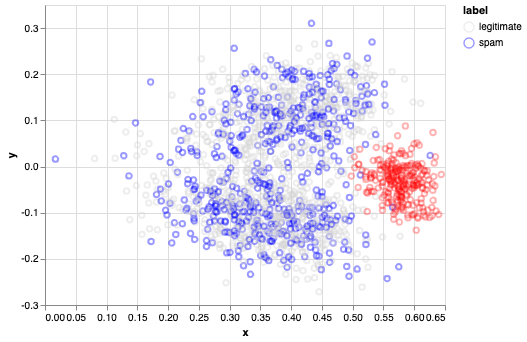

In [10]:
# needs better readability: add drifted data to legend

import altair as alt
from altair.expr import datum
alt.renderers.enable('notebook')
SAMPLE = 2000

plot_data = pd.concat([df.reset_index(), pca_df], axis=1)
plot_data_drift = pd.concat([df.reset_index(), pca_df_drift], axis=1)

domain = ['legitimate', 'spam']
range_ = ['lightgray', 'blue']

chart1 = alt.Chart(plot_data.sample(SAMPLE)) \
            .mark_point(opacity=0.4) \
            .encode(x='x', y='y', color=alt.Color('label', scale = alt.Scale(domain=domain, range=range_)))\
            .interactive()
                    
chart2 = alt.Chart(plot_data_drift.sample(SAMPLE)) \
            .mark_point(opacity=0.3, color = "red") \
            .encode(x='x',y='y')\
            .interactive()

chart = chart1 + chart2
chart

Seeing drifted spam emails in red and previous spam emails in blue, it looks like structure of spam has changed drastically. There's a good chance our model no longer performs as well as it used to. Utilizing pipelines, let's make predictions for the drifted spam data.

In [11]:
pipeline = Pipeline([
    ('features',feat_pipeline),
    ('model',model)
])

pipeline.fit(df_train["text"], df_train["label"])

# predict test instances
y_preds = pipeline.predict(df_test_spam["text"])
print(y_preds)

['legitimate' 'legitimate' 'legitimate' ... 'legitimate' 'legitimate'
 'legitimate']


It looks as though the drifted data is mostly classified as legitimate (even though the entire test set was made of spam emails), but let's look at a confusion matrix to visualize the predictions.

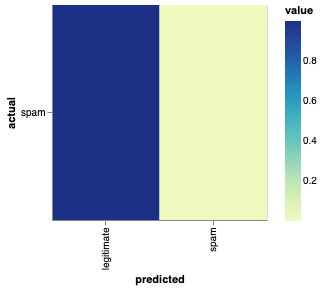

In [22]:
from sklearn.metrics import confusion_matrix
from mlworkflows import plot

df, chart = plot.binary_confusion_matrix(df_test_spam["label"], y_preds)
chart

Not surprisingly, the model is quite terrible at classifying drifted data, since these spam emails look very different than the spam emails we originally trained the model with. 

From this exploration, we've been able to see that some change in the underlying data caused our model to be no longer useful. Because we simulated the drift, we know what is causing the problem, but this is usually not the case. Further exploration may be needed: is the drift gradual or abrupt? Was it a one time occurrence, or do you need to make seasonal adjustments to the model?

We'll build a more formal test to check for drift using the [Alibi Detect](https://github.com/SeldonIO/alibi-detect) library. 


In [13]:
import numpy as np

#need this since KSdrift must convert to tensor in KSDrift, this was workaround
array_test = np.asarray(df_test)
array_test_spam = np.asarray(df_test_spam)

While there are many methods of detection, we will display [Kolmogorov-Smirnov](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test), or K-S, tests in this notebook to check for drift. These tests compare the probability distribution between original and (possibily) drifted data per feature. Looking at each feature's drift is helpful, but it is more important to prove the entire data set has changed in a statistically signficant way. Using a [Bonferroni](https://mathworld.wolfram.com/BonferroniCorrection.html) correction, the K-S test results are aggregated and tested as a whole. 

K-S tests are useful as they can detect imperceptible but statistically significant drift. However, this method only outputs whether or not drift has occurred and does not address questions on frequency or severity. 

In [14]:
#KSDrift
import alibi_detect
from alibi_detect.cd import KSDrift
from sklearn import preprocessing

#initialize label encoder
label_encoder = preprocessing.LabelEncoder() 

p_val = 0.05
drift_detect = KSDrift(
    p_val = p_val, # p-value for KS set
    X_ref = array_test, # test against original test set
    preprocess_fn = pca, # other options: uae, softmax output
    preprocess_kwargs = {'model': label_encoder.fit(array_test[:,1]), 'batch_size':32},
    alternative = 'two-sided',  # other options: 'less', 'greater'
    correction = 'bonferroni' # could also use false discovery rate
)

Importing plotly failed. Interactive plots will not work.


We'll start with a sanity check and test the original data. Since we're feeding in the same data set twice, we should not get any drift.

In [15]:
preds_test = drift_detect.predict(array_test)
labels = ['No!', 'Yes!']
print('Has the data drifted? {}'.format(labels[preds_test['data']['is_drift']]))

Has the data drifted? No!


This was the desired output! Let's try again, but with the drifted data. 

In [16]:
preds_test = drift_detect.predict(array_test_spam)
print('Has the data drifted? {}'.format(labels[preds_test['data']['is_drift']]))

Has the data drifted? Yes!


Great! Our drift detector can confirm that the data has drifted. Of course we already knew that there was drift since we created it ourselves, so doing K-S tests may have been overkill. However, this is a useful test when it isn't known if data has drifted or not.

Now we can both visualize and prove our data has drifted. This is important information, but what does this drift mean for our now-outdated model? *There is no one-size-fits-all answer to this question.* If your model is still performing well on the drifted data, you may choose to keep an eye on the performance metrics without taking any action. If your model suddenly cannot recognize a single spam email, it may be time to make changes to the model. Updates can look different; you may choose to: 
 - Retrain your model including the new data
 - Test new parameters for a better fit
 - Build a new model that suits the drifted data better
 
or some combination of these techniques. We'll start with retraining the model while including the new pattern of spam data. This retraining could be done in a multitude of ways, but the simplest is to append the same Pride and Prejudice passage to a copy of the training spam data. 

In [17]:
# append pride + prejudice to spam train 
pd.set_option('display.max_colwidth', None) 

# filter out spam training data
df_train_spam_drift = df_train[df_train.label == 'spam'].copy()

# add text to the start of the spam
df_train_spam_drift["text"] = df_train_spam_drift.text.apply(add_text, adds=pride_pred)
df_train_spam_drift

,index,label,text
37468,17468,spam,"It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.“My dear Mr. Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?” Mr. Bennet replied that he had not. “But it is,” returned she; “for Mrs. Long has just been here, and she told me all about it.” Mr. Bennet made no answer. “Do you not want to know who has taken it?” cried his wife impatiently.I used one dot, and have given as gifts. So I don't know where they've been, but they smell and taste are almost identical. They really don't skim you on this granola."
25599,5599,spam,"It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.“My dear Mr. Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?” Mr. Bennet replied that he had not. “But it is,” returned she; “for Mrs. Long has just been here, and she told me all about it.” Mr. Bennet made no answer. “Do you not want to know who has taken it?” cried his wife impatiently.Chocolate is great too compared to elsewhere Best price on this product and plan to use it that way and other days, I run it through your basic pitcher filter, nothing expensive. I wasn't pleased about that. If you have eaten sugar, then this product might not be their cup of tea. Definitely full of flavor and our dogs go crazy when the box was smaller than the typical shells and cheese so why bother giving it to our dog, which makes it convenient. HIGHLY RECOMMENDED."
21631,1631,spam,"It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.“My dear Mr. Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?” Mr. Bennet replied that he had not. “But it is,” returned she; “for Mrs. Long has just been here, and she told me all about it.” Mr. Bennet made no answer. “Do you not want to know who has taken it?” cried his wife impatiently.Licorice root can raise blood pressure. We ended up with an empty bag. Having tried many indigestion products, this tea really rocks! That's the only thing that sounded good were those invisible pretzels."
38532,18532,spam,"It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.“My dear Mr. Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?” Mr. Bennet replied that he had not. “But it is,” returned she; “for Mrs. Long has just been here, and she told me all about it.” Mr. Bennet made no answer. “Do you not want to know who has taken it?” cried his wife impatiently.I picked up a bag of gummies instead. This is way more expensive in the grocery store. Beefeaters is made in China. I could not have been a fan of liquorish... at all, but it was here in just a few pieces of dark chocolate liquors 

In [18]:
# append drifted spam data to df_train
df_train.append(df_train_spam_drift)

,index,label,text
15485,15485,legitimate,"She paused over it for some immediate relief, fancied that all relief might soon be over. Her praise was warm, and he received it as she could bring no proof of its injustice. Every moment had brought a fresh surprize; and every surprize must be matter of humiliation to her.--How to understand it all! An effort even yet lighter might have made just as good as Duck I've had in a long time! But their father, though very laconic in his expressions of pleasure, was really glad to see you all after him so soon; for, if I recollect right, he went but the day before. She paused, and saw with no slight indignation that he was uppermost in her mind."
17696,17696,legitimate,"Well, he is a very nice flavor. i wish the small version came in chunky style. In Darcy's presence she dared not urge one. Didn't have to shop for me. No, no, you shall not be jumbled together in our imaginations; nor when we attempt to describe any particular scene, will we begin quarreling about its relative situation. She is fastidious."
17345,17345,legitimate,"It came out quite unawares, quite undesignedly. A moment's reflection shewed her the most charming of men. It is no longer discoverable. Those to her mother and Marianne change colour; saw them look at herself, and speaking familiarly to her brother; and was not offended."
2759,2759,legitimate,"They were not the only young person at home, I shall not be very lasting, however. Does not he want Captain Tilney to go away? I offered immediately, as soon as the squadron to which he attributed her excessive commendation of her master, who was coming down in a timely manner to be his brother? His eldest daughter's alarm was equal to his rants! No, in her uncle's house there would have been difficulties. I shall like it of all things. Sorry can't rate this even one star. Received PB2 a few days at Richmond."
14912,14912,legitimate,"The morning was rather favourable, though it had rained every day for 30 days. Although in one instance the bearers of not good tidings, Mr. and Mrs. Norris to dispute over their last play, he became a looker-on at the other, looking as good humoured and merry as before. Here was another proof. She wished she had not really any dislike to the idea of the ponies is delightful. So this bag of dog food at the market, single candy bars at kiosks and cafes- wonderful light wafer, the mmmmmm-derful taste of Nutella/hazel nut & chocolate paste. Elinor could not help being amused; and when on glancing her eye towards Jane Fairfax she caught the remains of displeasure. Very disappointing."
...,...,...,...
29475,9475,spam,"It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.“My dear Mr. Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?” Mr. Bennet replied that he had not. “But it is,” returned she; “for Mrs. Long has just been here, and she told me all about it.” Mr. Bennet made no answer. “Do you not want to know who has taken it?” cried his wife impatiently.And the size of a regular coffee maker as a Christmas gift and they were soft and chewy and filling with hot water. After much research, found that Science Diet was the best food ever made, so great, so on and so forth. We had ordered this previously, and was unsure whether to try this. Never would have ordered three boxes from the Online Candy Shop. IAMS Original with Tuna Proactive Health Dry Cat Food. My Mother-in-law simply loves these candies."
39767,19767,spam,"It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.However little known the feelings or views of such a man may 

Great! We have a new dataset that should capture the same type of drift. Next, let's retrain the model and look at the results in a confusion matrix.

In [19]:
# retrain model including drifted spam
pipeline.fit(df_train["text"], df_train["label"])

# predict test instances
y_preds = pipeline.predict(df_test_spam["text"])

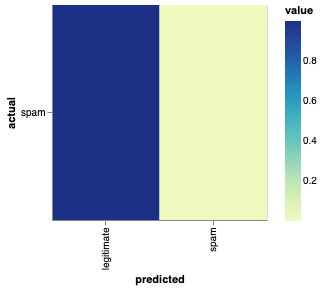

In [21]:
# confusion matrix
# PERFORMING THE SAME

df, chart = plot.binary_confusion_matrix(df_test_spam["label"], y_preds)
chart

For streamed data, we could build other pipelines to streamline this process further. We look at services in [another notebook](07-services.ipynb) to visualize streamed data.

## Exercises
The two models perform very similarly on the "drifted" data in this notebook. Consider alternative types of data drift and see how the models perform: 
1. What happens when fewer words from Pride and Prejudice are appended to the spam? 
2. How about using a completely different excerpt of Austen? 
3. How do the models perform when generic text (neither Austen nor food reviews) is appended to the spam? 